## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_horizontal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


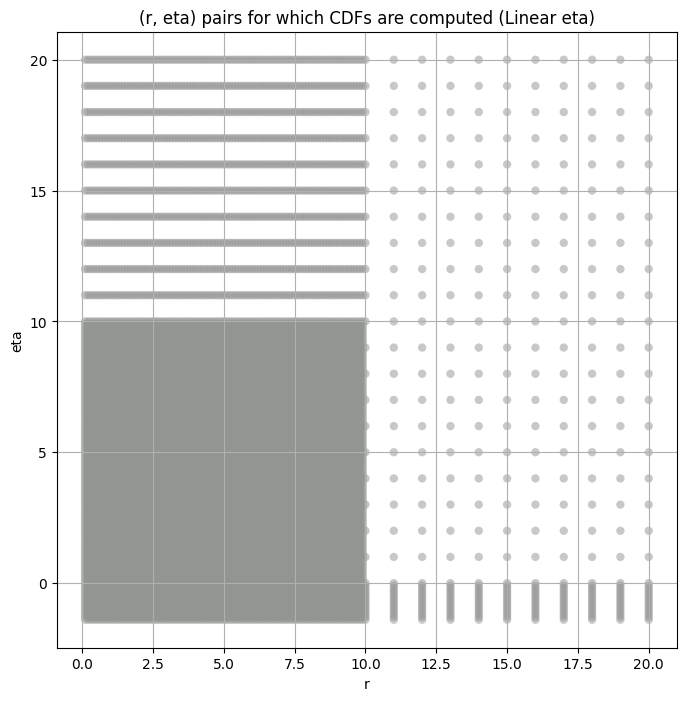

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.154161e+07  2.893149e+07  3.426387e+07   0.638397    0.345434   
3      6.082628e+06  5.795836e+06  6.381056e+06   1.415760    1.172051   
4      1.234281e+06  1.166479e+06  1.304524e+06   2.704583    2.289594   
5      2.341533e+05  2.191249e+05  2.496854e+05   4.474215    3.884163   
6      4.525257e+04  4.182397e+04  4.885501e+04   7.118702    6.031174   
7      8.730283e+03  7.959781e+03  9.548441e+03  10.400122    8.524142   
8      1.847510e+03  1.666143e+03  2.040041e+03  13.392334   10.982724   
9      4.805932e+02  4.326155e+02  5.322186e+02  14.466990   11.813130   

       kurt_upper  total_samples  
layer                             
2        0.948272           2446  
3        1.673472           9784  
4        3.160065          39136  
5        5.119264         156544  
6        8.409040         626176  
7       12.878841        2504704  
8       16.352785       10018816  
9       17.756971       40075264

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      3.154161e+07   3.154161e+07    2.655835e+07    2.353646e+07   
3      6.082628e+06   6.082628e+06    5.671474e+06    5.380494e+06   
4      1.234281e+06   1.234281e+06    1.197648e+06    1.170522e+06   
5      2.341533e+05   2.341533e+05    2.303635e+05    2.272899e+05   
6      4.525257e+04   4.525257e+04    4.419067e+04    4.337914e+04   
7      8.730283e+03   8.730283e+03    8.452744e+03    8.255859e+03   
8      1.847510e+03   1.847510e+03    1.779937e+03    1.729940e+03   
9      4.805932e+02   4.805932e+02    4.620691e+02    4.484706e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        2.113947e+07     1.914620e+07     1.597408e+07     1.341083e+07   
3        5.145514e+06     4.938272e+06     4.579304e+06     4.272143e+06   
4        1.147121e+06     1.126271e+06     1.089089e+06     1.056094e+06   
5        2.244970e+05     2.218939e+05     2.171559e+05     2.128557e+05   
6        4.267406e+04     4.203187e+04     4.087541e+04     3.985055e+04   
7        8.085919e+03     7.932912e+03     7.662677e+03     7.425729e+03   
8        1.687079e+03     1.648806e+03     1.581712e+03     1.523575e+03   
9        4.368073e+02     4.264100e+02     4.082162e+02     3.925052e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         1.138923e+07     9.698614e+06     8.246936e+06     5.008096e+06  
3         4.005090e+06     3.771999e+06     3.561768e+06     3.033147e+06  
4         1.026376e+06     9.990083e+05     9.733993e+05     9.049164e+05  
5         2.089163e+05     2.052564e+05     2.018032e+05     1.924890e+05  
6         3.892017e+04     3.806026e+04     3.726272e+04     3.514103e+04  
7         7.212665e+03     7.018063e+03     6.838727e+03     6.369842e+03  
8         1.471899e+03     1.425208e+03     1.382585e+03     1.272787e+03  
9         3.785890e+02     3.660569e+02     3.546263e+02     3.252870e+02

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.03607893820703084 31541612.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.037345868708277496 26558346.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.048894654295866924 23536464.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.061157594405691906 21139474.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.07217604326643368 19146196.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.09137310638732787 15974076.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.11024193276836647 13410831.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.1284669401072619 11389229.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.14539618810712363 9698614.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.16265835412275875 8246936.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.21204588019345627 5008096.0
Number of samples: 2446, Without approximation : 2446


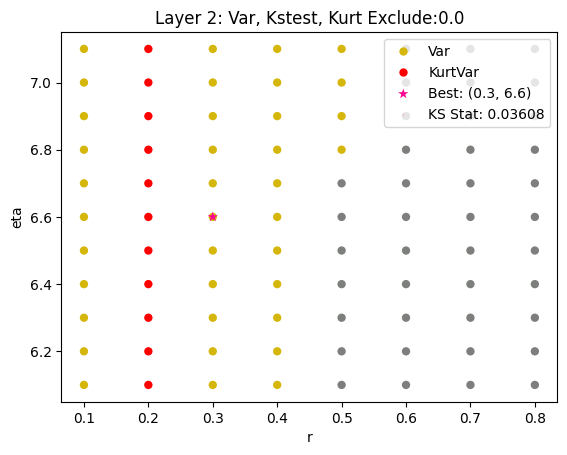

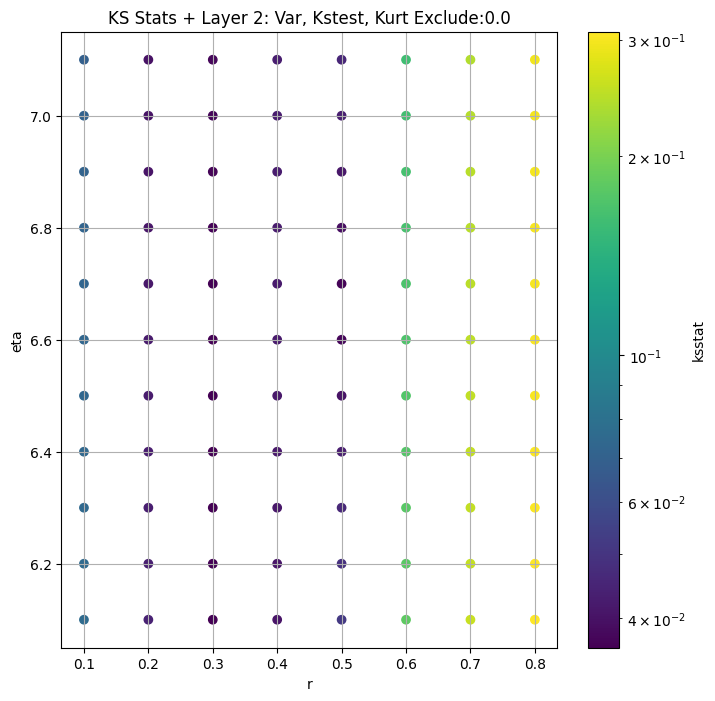

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.028637926321534224 6082628.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.029243654646564754 5671473.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.029405562970145016 5380493.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.03007216745589225 5145514.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.031215723479024682 4938271.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.034401616263053825 4579304.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.037375877638626376 4272143.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.04123189815128514 4005090.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.04632894036103086 3771999.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.05127913786502636 3561767.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.0663440421466952 3033147.0
Number of samples: 9784, Without approximation : 9784


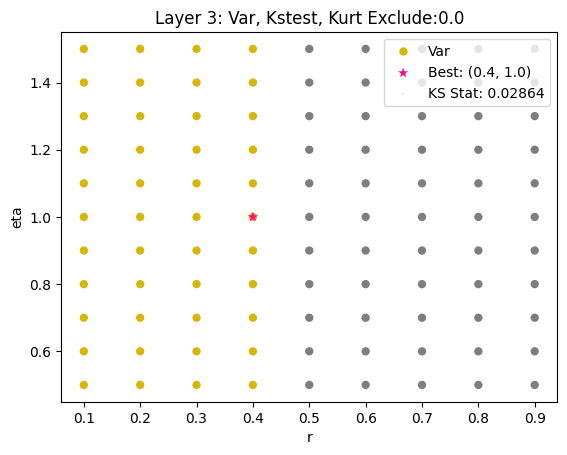

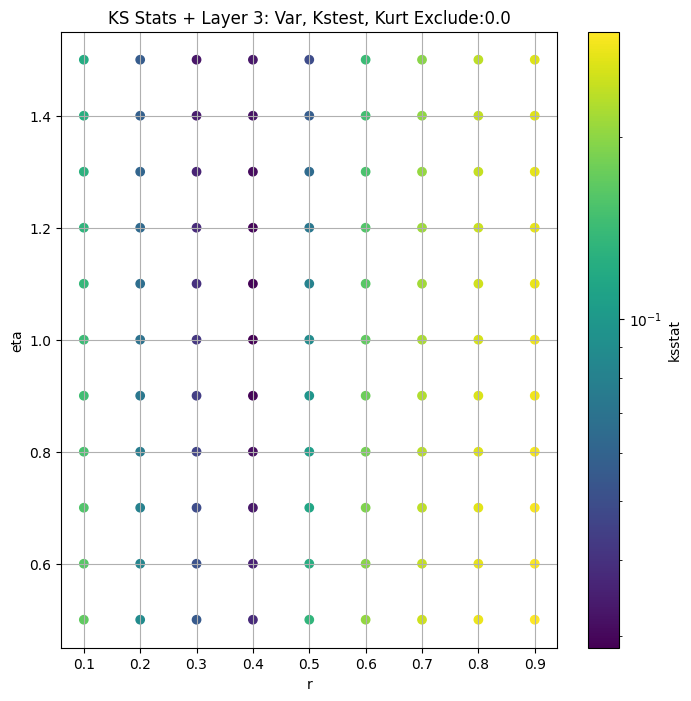

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.023537080080119843 1234280.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.02318600943369109 1197648.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.024435893339716352 1170521.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.024013871478266724 1147120.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.025292777476969563 1126270.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.02532033624097202 1089088.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.025167768942867375 1056093.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.026529024673200563 1026376.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.02688773888309337 999008.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.02725228347969777 973399.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.030229191385244825 904916.44
Number of samples: 39136, Without approximation : 39136


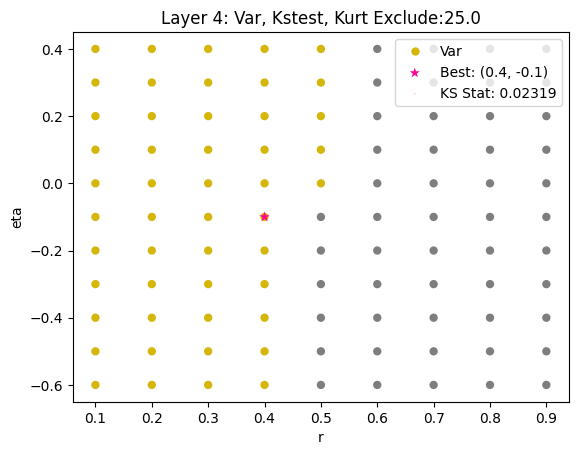

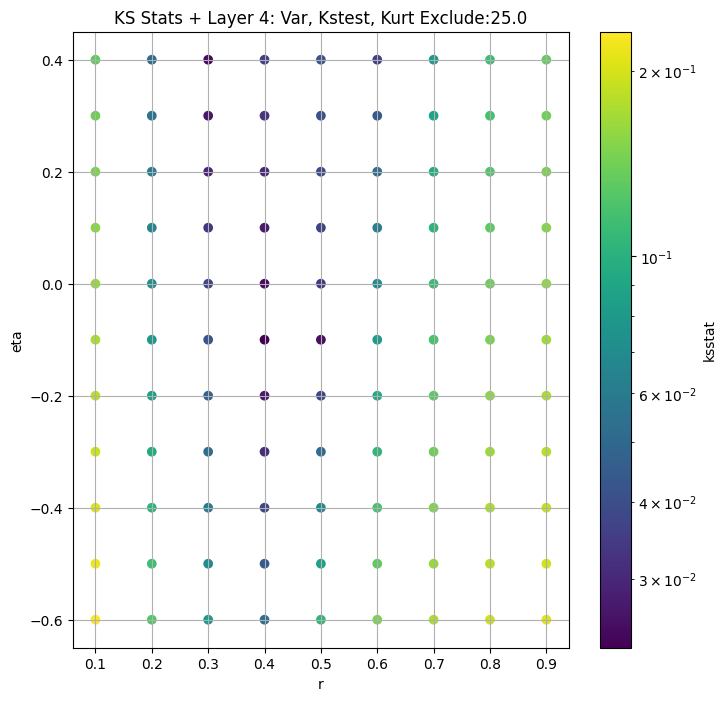

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.017056044968168038 234153.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.018169606560291984 230363.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.018943988344045815 227289.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.018667530928323628 224497.02


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.018729574539177563 221893.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.01976228957089321 217155.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.019263012071058405 212855.69


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.018847738239817058 208916.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.018451971564607317 205256.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.019351489304568315 201803.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.02278060857527986 192489.02
Number of samples: 100000, Without approximation : 156544


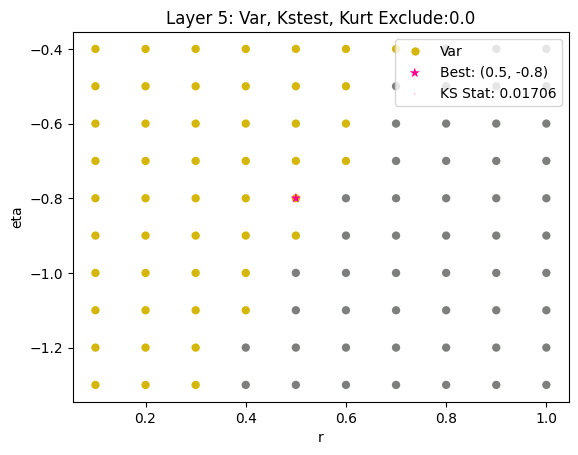

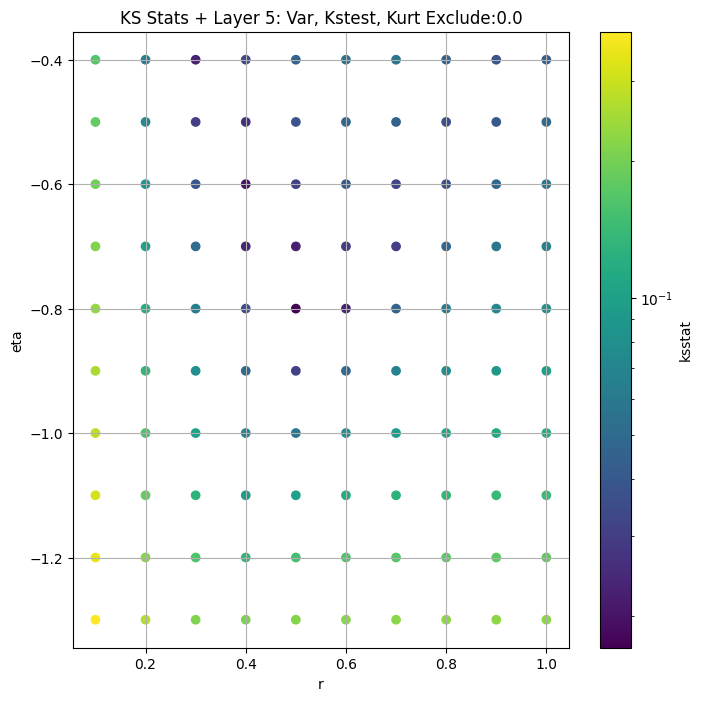

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.020100256817139783 45252.566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.01931319347912508 44190.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.019249462072145285 43379.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.019470322045911592 42674.062


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.01967585782816783 42031.87


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.020057006837315705 40875.406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.020407274781585216 39850.547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.020736074215182865 38920.168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.020832475327186906 38060.258


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.020124033638536154 37262.723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.019352750983812672 35141.027
Number of samples: 100000, Without approximation : 626176


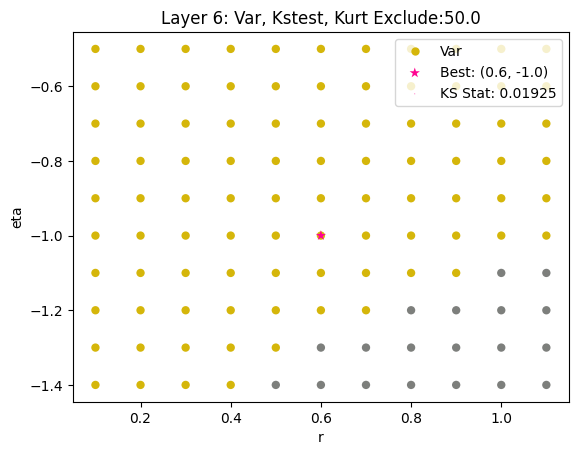

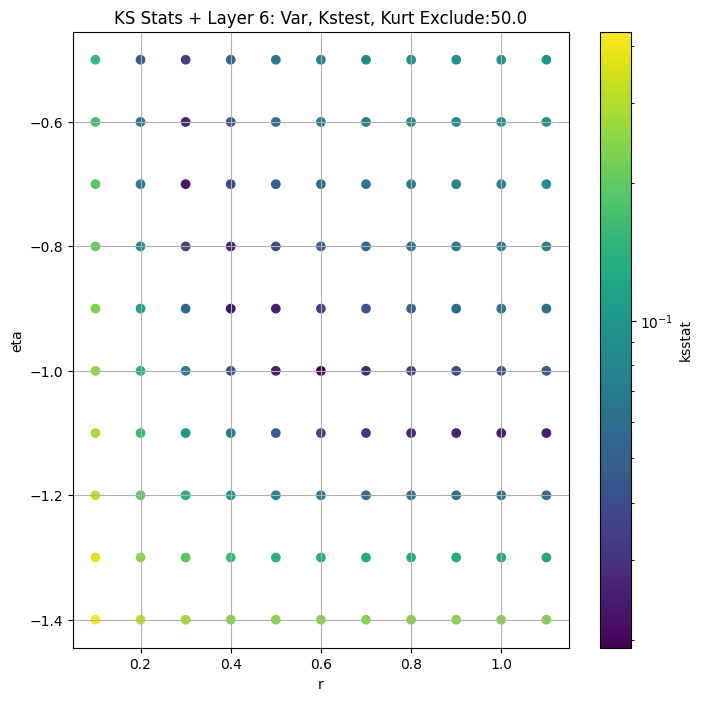

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.02344588397264255 8730.283


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.021780158962241614 8452.744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.02159362317277036 8255.859


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.021428355456815484 8085.919


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.02127718866235967 7932.912


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.02105541306907399 7662.677


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.022041092340019164 7425.7285


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.021965741347814705 7212.665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.021750446784971456 7018.063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.021544821074270082 6838.7266


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.021799187267216857 6369.842
Number of samples: 100000, Without approximation : 2504704


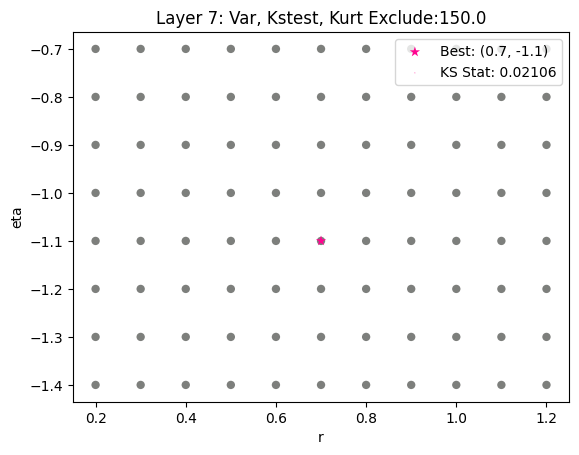

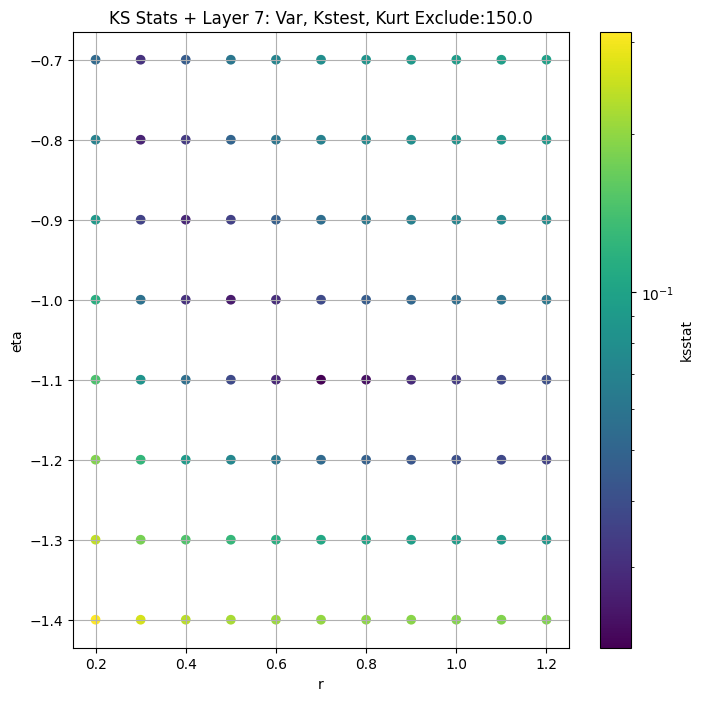

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.011378652881651241 1847.5098


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.00924337577679224 1779.9374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.00896714879586813 1729.9396


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.009946732497737698 1687.0787


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.01085179052342744 1648.8064


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.012503067902403742 1581.712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.011399984339869468 1523.575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.011633953232521255 1471.8987


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.012782212941055526 1425.2083


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.013876465457528853 1382.5846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010945247318669749 1272.7872
Number of samples: 100000, Without approximation : 10018816


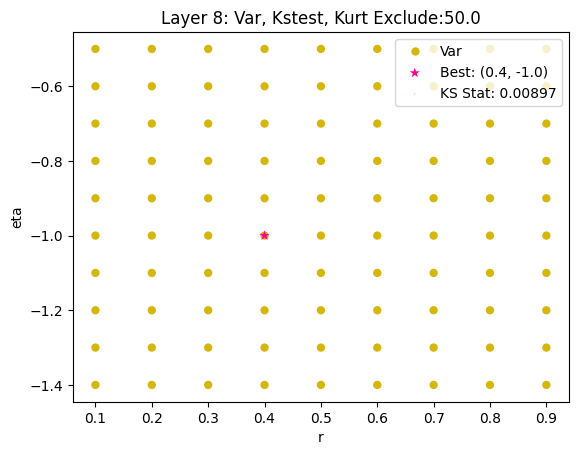

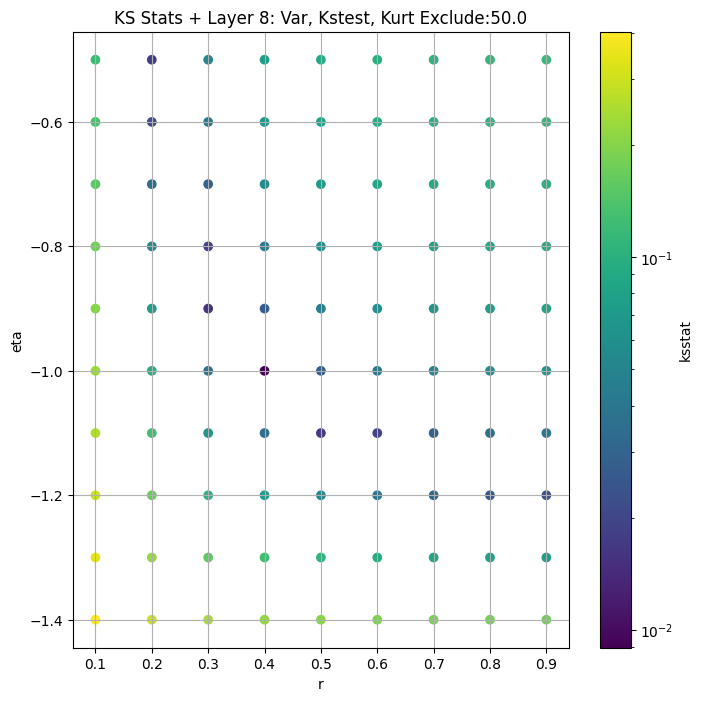

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.014681722577682188 480.59317


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.013685317932793928 462.06906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.012285372572865716 448.47055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.011201977145424424 436.80728


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.010337004752993595 426.40997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.010689105087132722 408.21625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.011013224509350383 392.50522


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.011322720980296186 378.58896


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.011623126284713181 366.05685


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.011492397436624668 354.62625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.011322787964233305 325.28696
Number of samples: 100000, Without approximation : 40075264


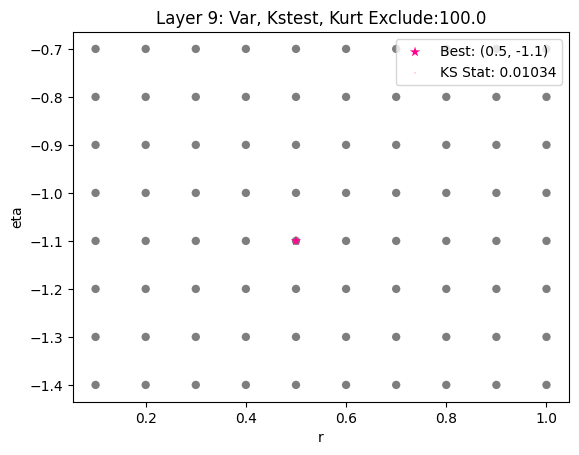

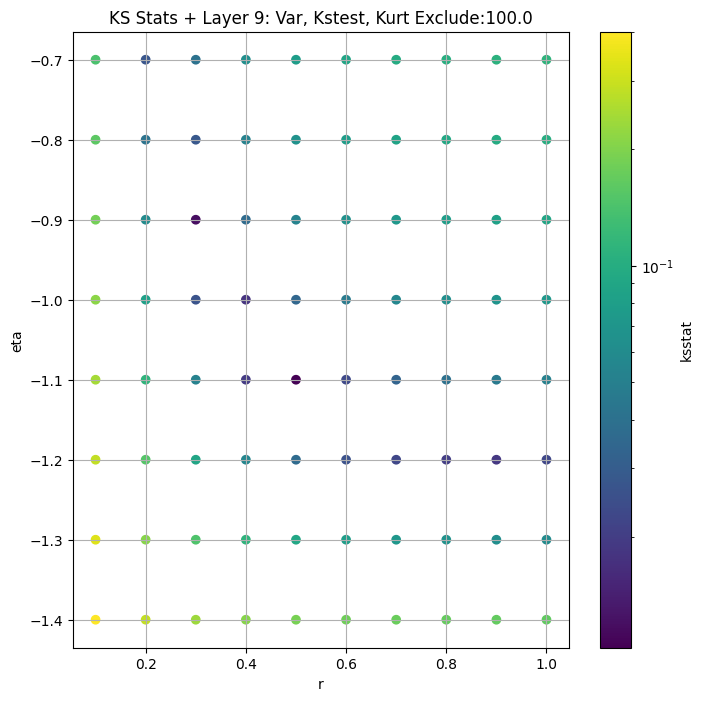

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.154161e+07  2.893149e+07  3.426387e+07   0.638397    0.345434   
3      6.082628e+06  5.795836e+06  6.381056e+06   1.415760    1.172051   
4      1.234281e+06  1.166479e+06  1.304524e+06   2.704583    2.289594   
5      2.341533e+05  2.191249e+05  2.496854e+05   4.474215    3.884163   
6      4.525257e+04  4.182397e+04  4.885501e+04   7.118702    6.031174   
7      8.730283e+03  7.959781e+03  9.548441e+03  10.400122    8.524142   
8      1.847510e+03  1.666143e+03  2.040041e+03  13.392334   10.982724   
9      4.805932e+02  4.326155e+02  5.322186e+02  14.466990   11.813130   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.948272           2446             0.036079        0.3          6.6   
3        1.673472           9784             0.028638        0.4          1.0   
4        3.160065          39136             0.023186        0.4         -0.1   
5        5.119264         156544             0.017056        0.5         -0.8   
6        8.409040         626176             0.019249        0.6         -1.0   
7       12.878841        2504704             0.021055        0.7         -1.1   
8       16.352785       10018816             0.008967        0.4         -1.0   
9       17.756971       40075264             0.010337        0.5         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2         464.731115                     0.0        3.154161e+07   
3       47448.501689                     0.0        6.082628e+06   
4       33168.385873                    25.0        1.197648e+06   
5       69688.495164                     0.0        2.341533e+05   
6       36834.667585                    50.0        4.337914e+04   
7       11942.902656                   150.0        7.662677e+03   
8         354.516307                    50.0        1.729940e+03   
9         296.118037                   100.0        4.264100e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.07671995300127321, var: 19146196.0


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.06652740041641925, var: 21139474.0


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.05519607025504347, var: 23536464.0


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.04212736560375718, var: 26558346.0


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.036071555017985146, var: 31541612.0
Number of samples: 2446, Without approximation : 2446


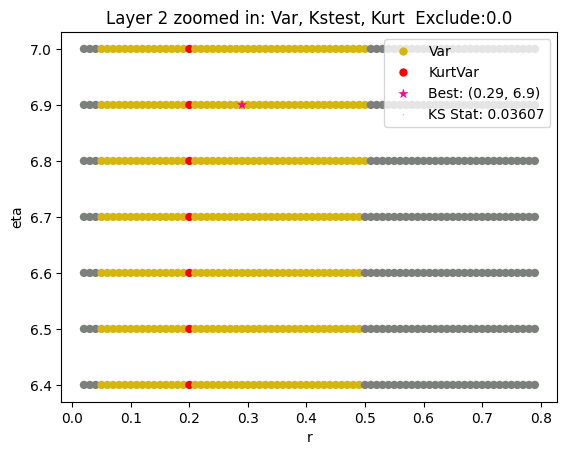

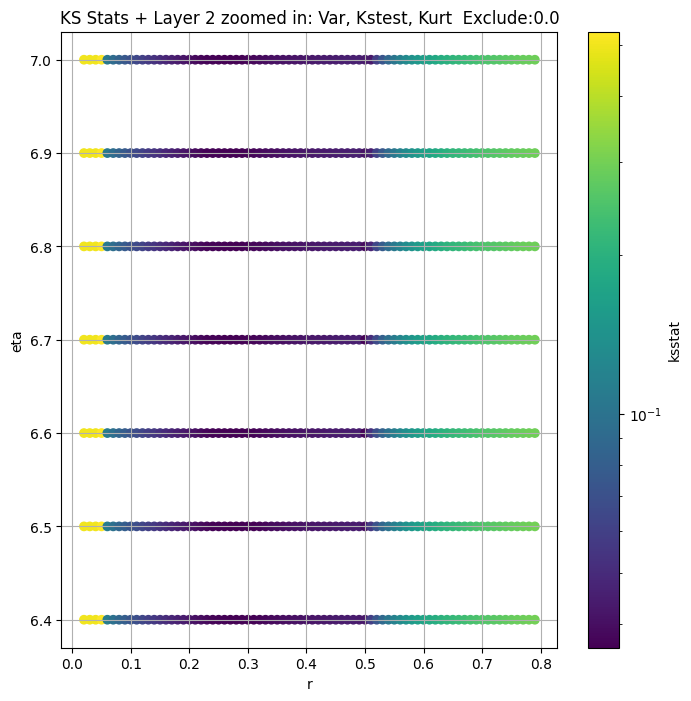

Layer 3


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.03495547272190991, var: 4938271.5


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.031529369269369334, var: 5145514.0


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.02933197691379852, var: 5380493.5


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.028946979916930127, var: 5671473.5


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.02838479350968315, var: 6082628.5
Number of samples: 9784, Without approximation : 9784


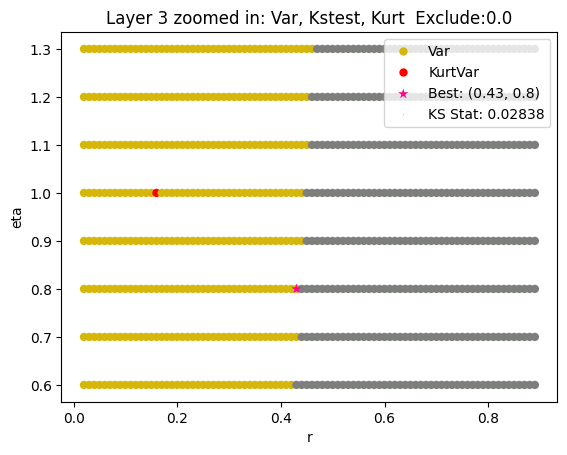

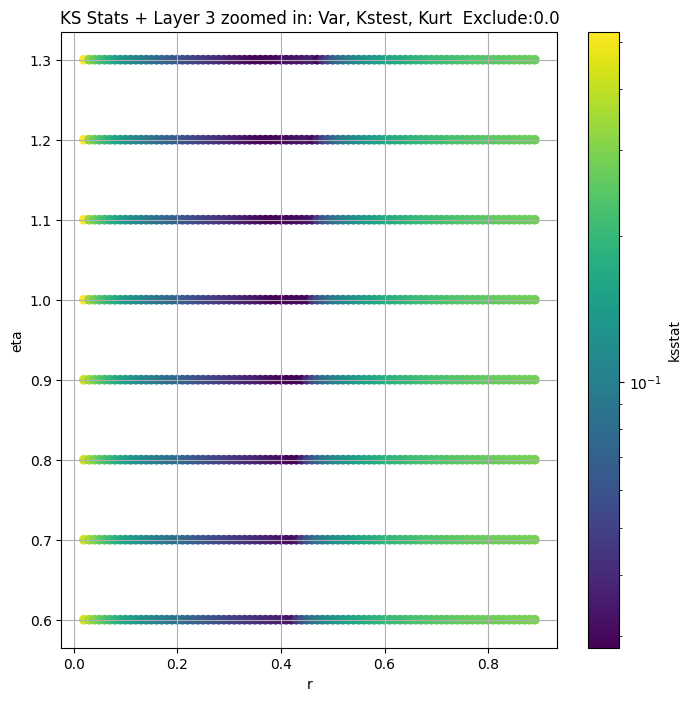

Layer 4


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.024225365858794645, var: 1107062.75


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.023641144068776154, var: 1126270.875


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.023369026237247237, var: 1147120.75


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.023073055073493498, var: 1170521.875


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.02297909399020892, var: 1197648.5


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.021915551705292857, var: 1234280.625
Number of samples: 39136, Without approximation : 39136


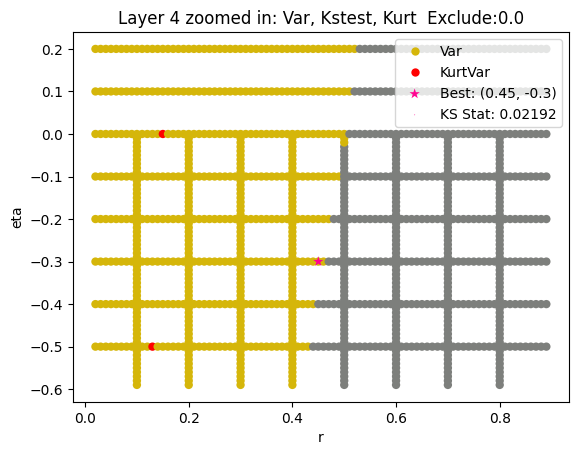

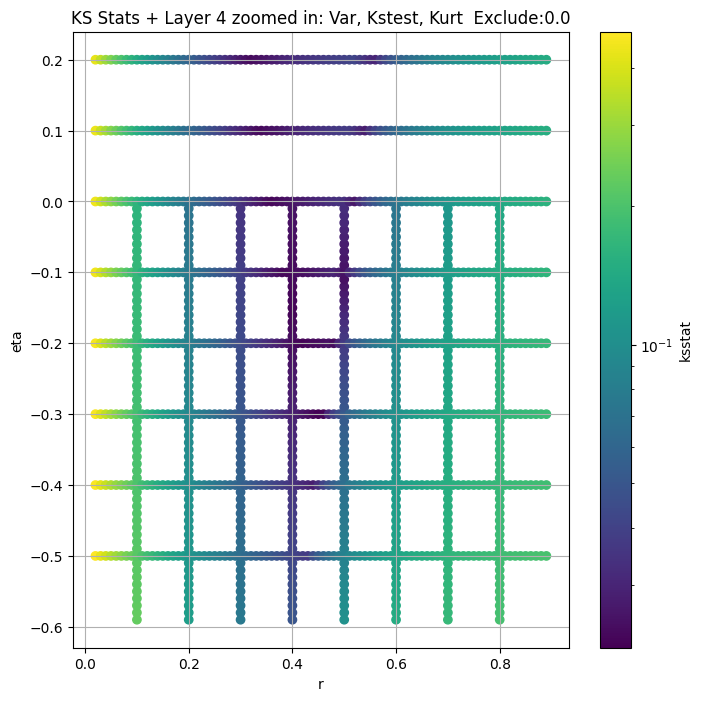

Layer 5


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.016629421214120255, var: 221893.890625


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.016639266106266204, var: 224497.015625


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.0166224515922635, var: 227289.90625


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.016633827558777903, var: 230363.5


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.016619190046764043, var: 234153.34375
Number of samples: 100000, Without approximation : 156544


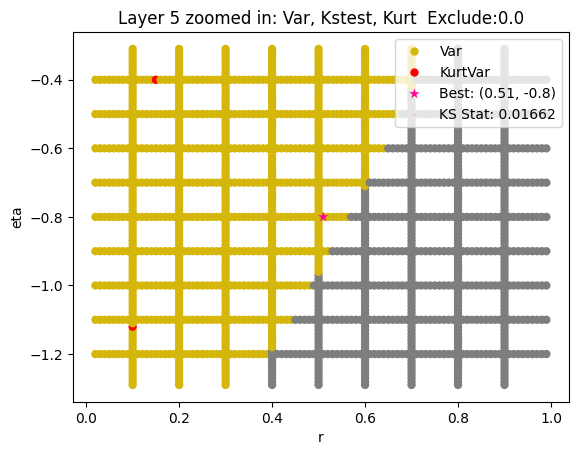

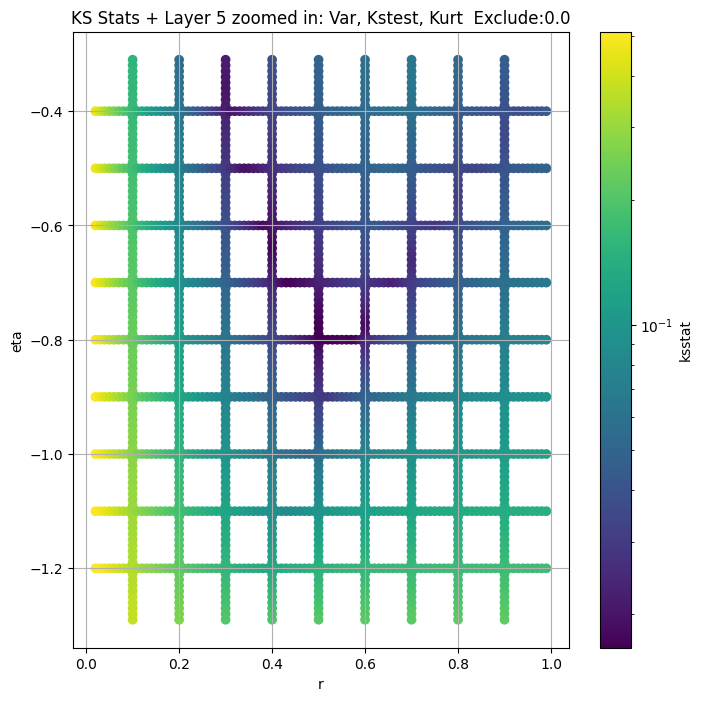

Layer 6


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.019318701679825134, var: 40875.40625


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.01927549679395374, var: 41434.0234375


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.019323435269679168, var: 42031.87109375


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.019284072222459037, var: 42674.0625


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.019249462072145285, var: 43379.140625


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.01931319347912508, var: 44190.671875


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.019315740724913155, var: 45252.56640625
Number of samples: 100000, Without approximation : 626176


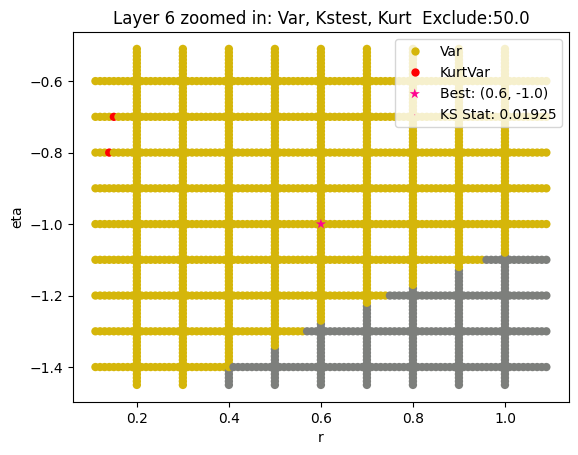

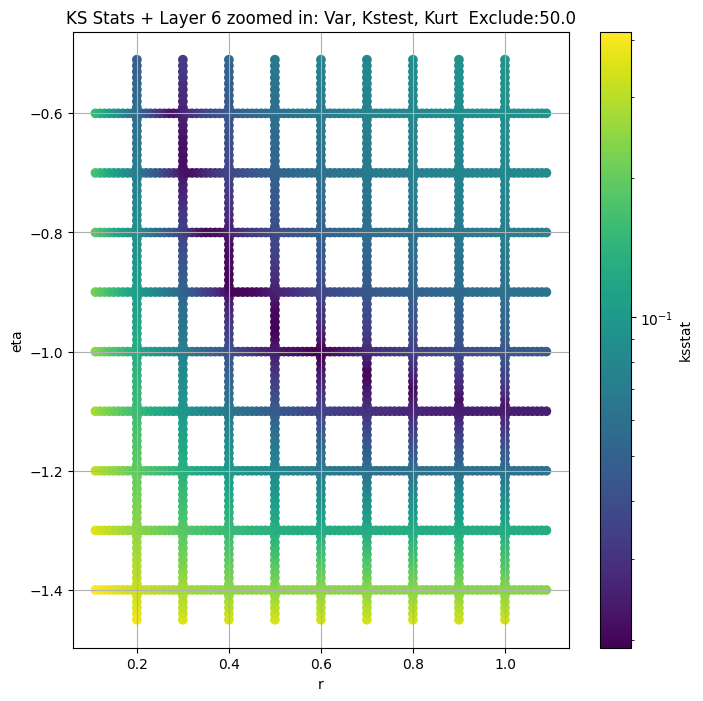

Layer 7


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.020625059839766646, var: 7212.6650390625


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.02089535081823518, var: 7316.6328125


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.0210129116734879, var: 7425.728515625


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.02065362700231843, var: 7540.84912109375


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.02105541306907399, var: 7662.6767578125


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.020702801973668694, var: 7792.74853515625


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.02035547268607177, var: 7932.912109375


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.02108026514435135, var: 8085.9189453125


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.0210623464515709, var: 8255.859375
Number of samples: 100000, Without approximation : 2504704


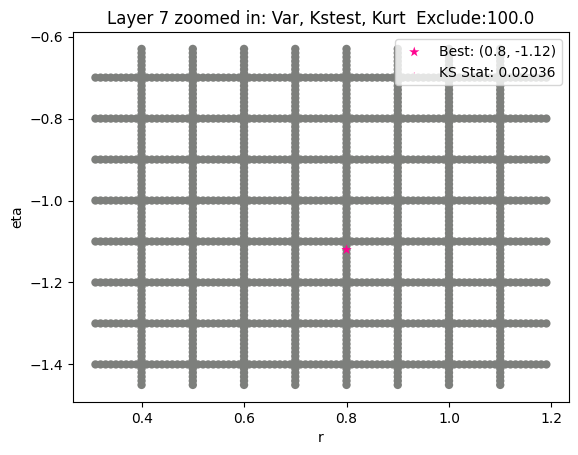

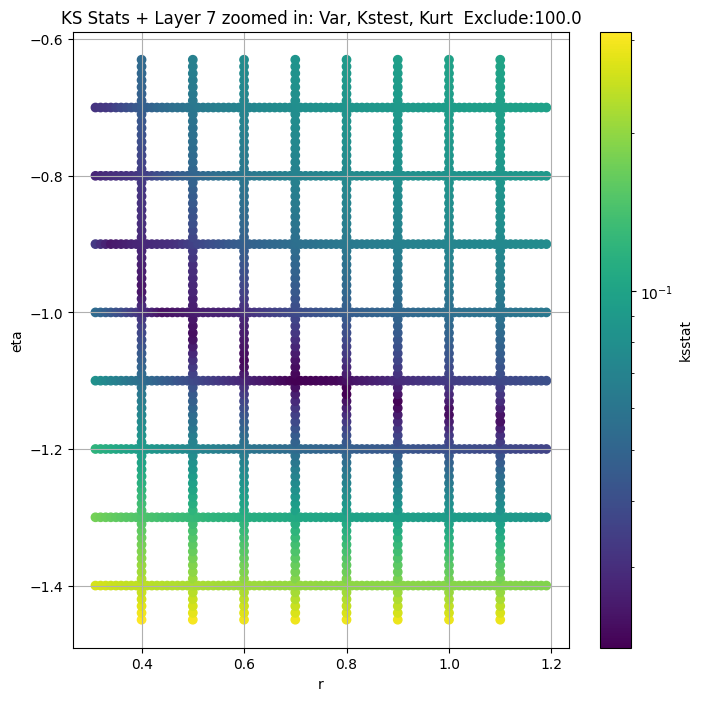

Layer 8


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 100 = 150, ksstat: 0.009168564404986035, var: 1581.7120361328125


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 75 = 125, ksstat: 0.009405434375293953, var: 1613.927978515625


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 50 = 100, ksstat: 0.008970990769868181, var: 1648.806396484375


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 25 = 75, ksstat: 0.009241541867268388, var: 1687.0787353515625


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 0 = 50, ksstat: 0.00896714879586813, var: 1729.9395751953125


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + -25 = 25, ksstat: 0.00924337577679224, var: 1779.9373779296875


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + -50 = 0, ksstat: 0.008863537168725899, var: 1847.509765625
Number of samples: 100000, Without approximation : 10018816


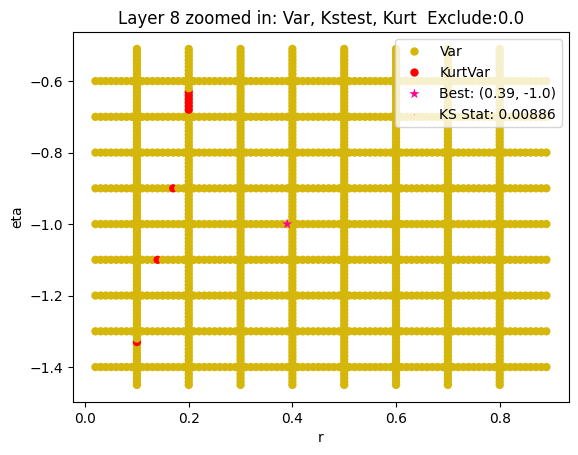

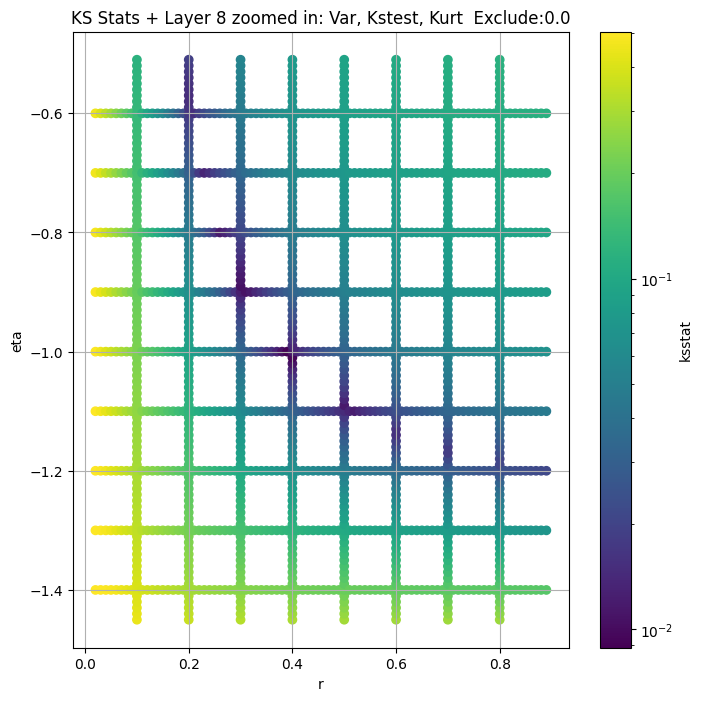

Layer 9


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 100.0 + 100 = 200, ksstat: 0.008608386022695202, var: 392.5052185058594


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 100.0 + 75 = 175, ksstat: 0.00838768931239825, var: 400.10235595703125


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 100.0 + 50 = 150, ksstat: 0.008652430226255392, var: 408.21624755859375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 100.0 + 25 = 125, ksstat: 0.008498265951401907, var: 416.9425048828125


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 100.0 + 0 = 100, ksstat: 0.008524472362579305, var: 426.40997314453125


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 100.0 + -25 = 75, ksstat: 0.008327101498314393, var: 436.8072814941406


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 100.0 + -50 = 50, ksstat: 0.008027442225184533, var: 448.4705505371094


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 100.0 + -75 = 25, ksstat: 0.007836419260839, var: 462.0690612792969


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 100.0 + -100 = 0, ksstat: 0.008053228172315074, var: 480.5931701660156
Number of samples: 100000, Without approximation : 40075264


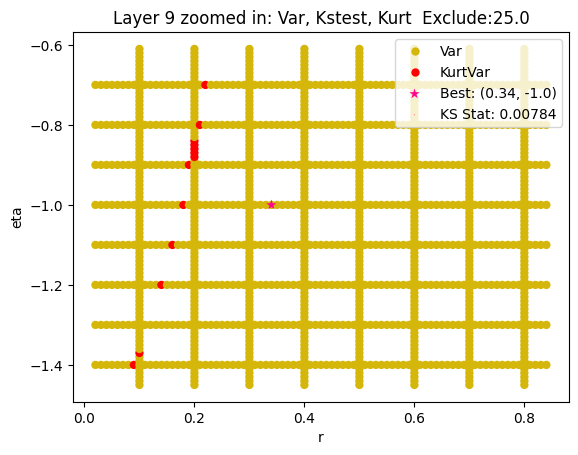

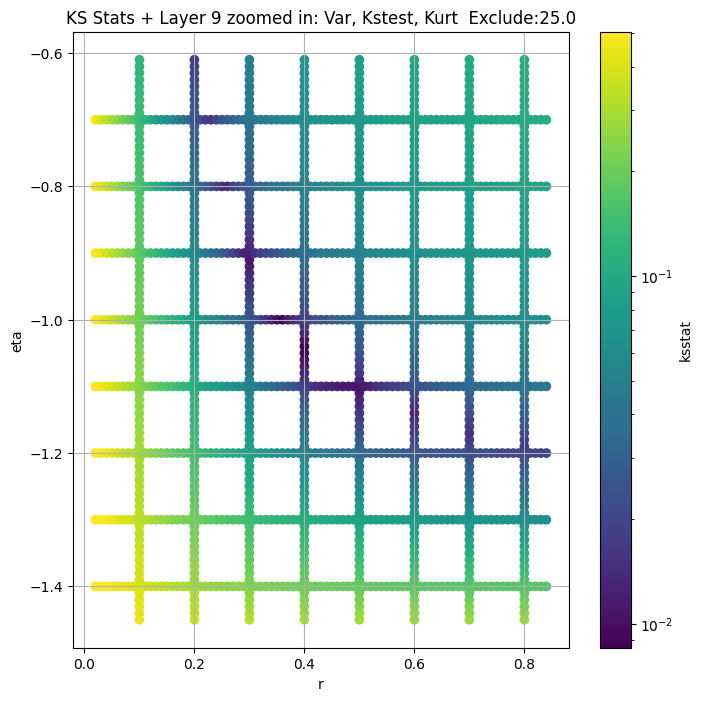

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.154161e+07  2.893149e+07  3.426387e+07   0.638397    0.345434   
3      6.082628e+06  5.795836e+06  6.381056e+06   1.415760    1.172051   
4      1.234281e+06  1.166479e+06  1.304524e+06   2.704583    2.289594   
5      2.341533e+05  2.191249e+05  2.496854e+05   4.474215    3.884163   
6      4.525257e+04  4.182397e+04  4.885501e+04   7.118702    6.031174   
7      8.730283e+03  7.959781e+03  9.548441e+03  10.400122    8.524142   
8      1.847510e+03  1.666143e+03  2.040041e+03  13.392334   10.982724   
9      4.805932e+02  4.326155e+02  5.322186e+02  14.466990   11.813130   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.948272           2446             0.036079        0.3          6.6   
3        1.673472           9784             0.028638        0.4          1.0   
4        3.160065          39136             0.023186        0.4         -0.1   
5        5.119264         156544             0.017056        0.5         -0.8   
6        8.409040         626176             0.019249        0.6         -1.0   
7       12.878841        2504704             0.021055        0.7         -1.1   
8       16.352785       10018816             0.008967        0.4         -1.0   
9       17.756971       40075264             0.010337        0.5         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2         464.731115                     0.0        3.154161e+07   
3       47448.501689                     0.0        6.082628e+06   
4       33168.385873                    25.0        1.234281e+06   
5       69688.495164                     0.0        2.341533e+05   
6       36834.667585                    50.0        4.337914e+04   
7       11942.902656                   150.0        7.932912e+03   
8         354.516307                    50.0        1.847510e+03   
9         296.118037                   100.0        4.620691e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.036072    0.29      6.90   
3                     0.013713          0.028385    0.43      0.80   
4                     0.006861          0.021916    0.45     -0.30   
5                     0.003431          0.016619    0.51     -0.80   
6                     0.001716          0.019249    0.60     -1.00   
7                     0.000858          0.020355    0.80     -1.12   
8                     0.000429          0.008864    0.39     -1.00   
9                     0.000215          0.007836    0.34     -1.00   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2        249.270528                  0.0         1375  
3      94983.476467                  0.0         2319  
4      91347.368339                  0.0         3669  
5      74937.157508                  0.0         6963  
6      36834.667585                 50.0         4892  
7      16190.233085                100.0         4641  
8        335.197751                  0.0        24765  
9         39.729830                 25.0        29352

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

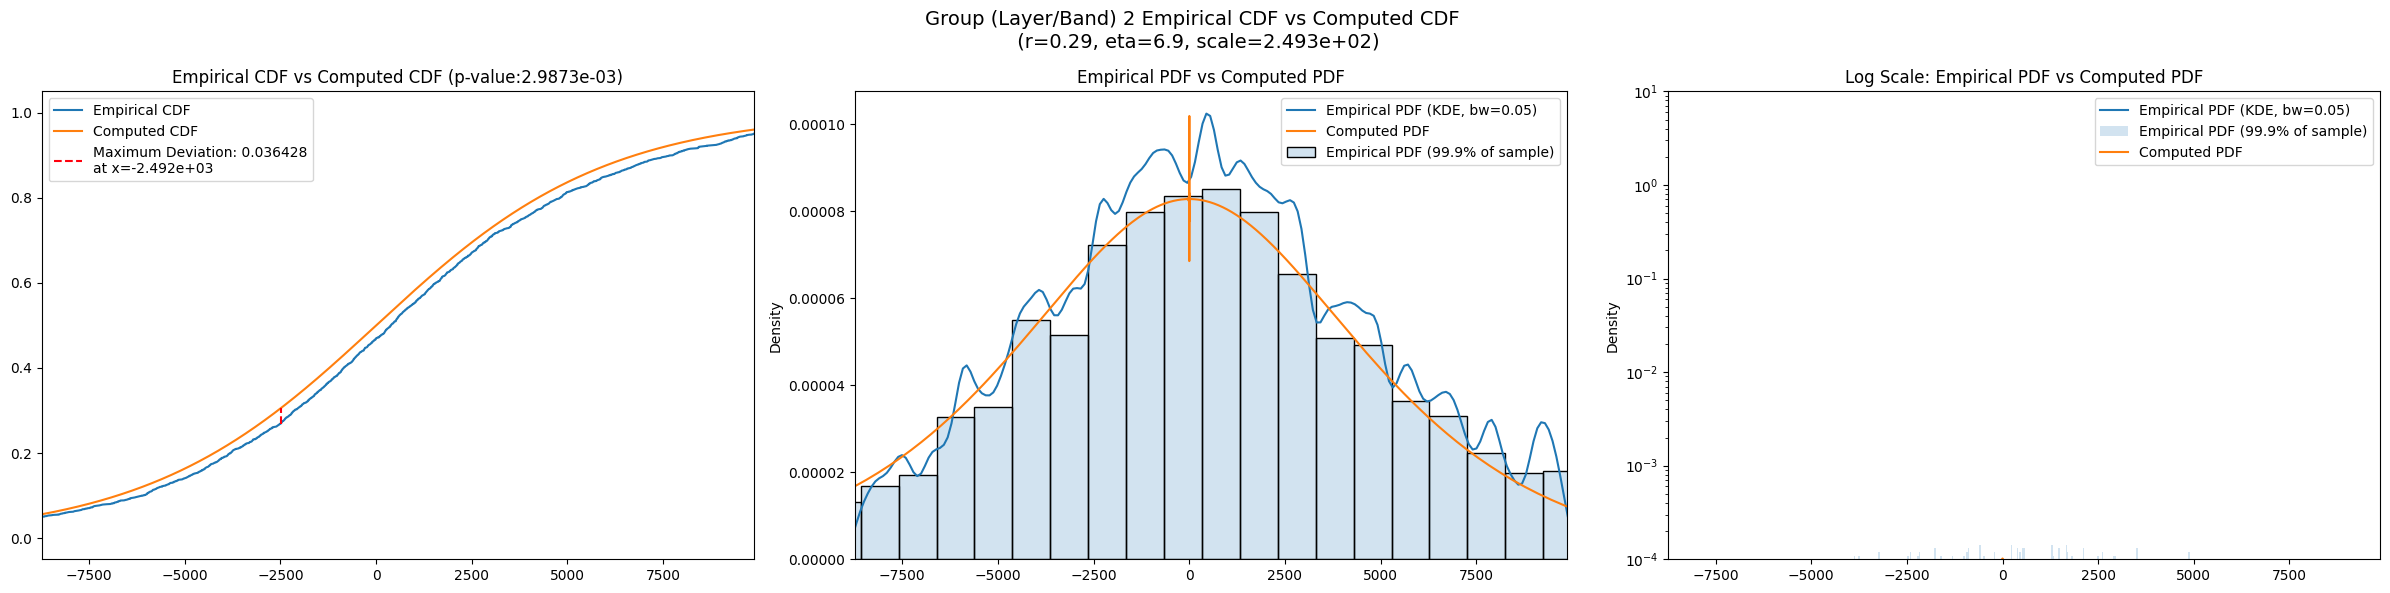

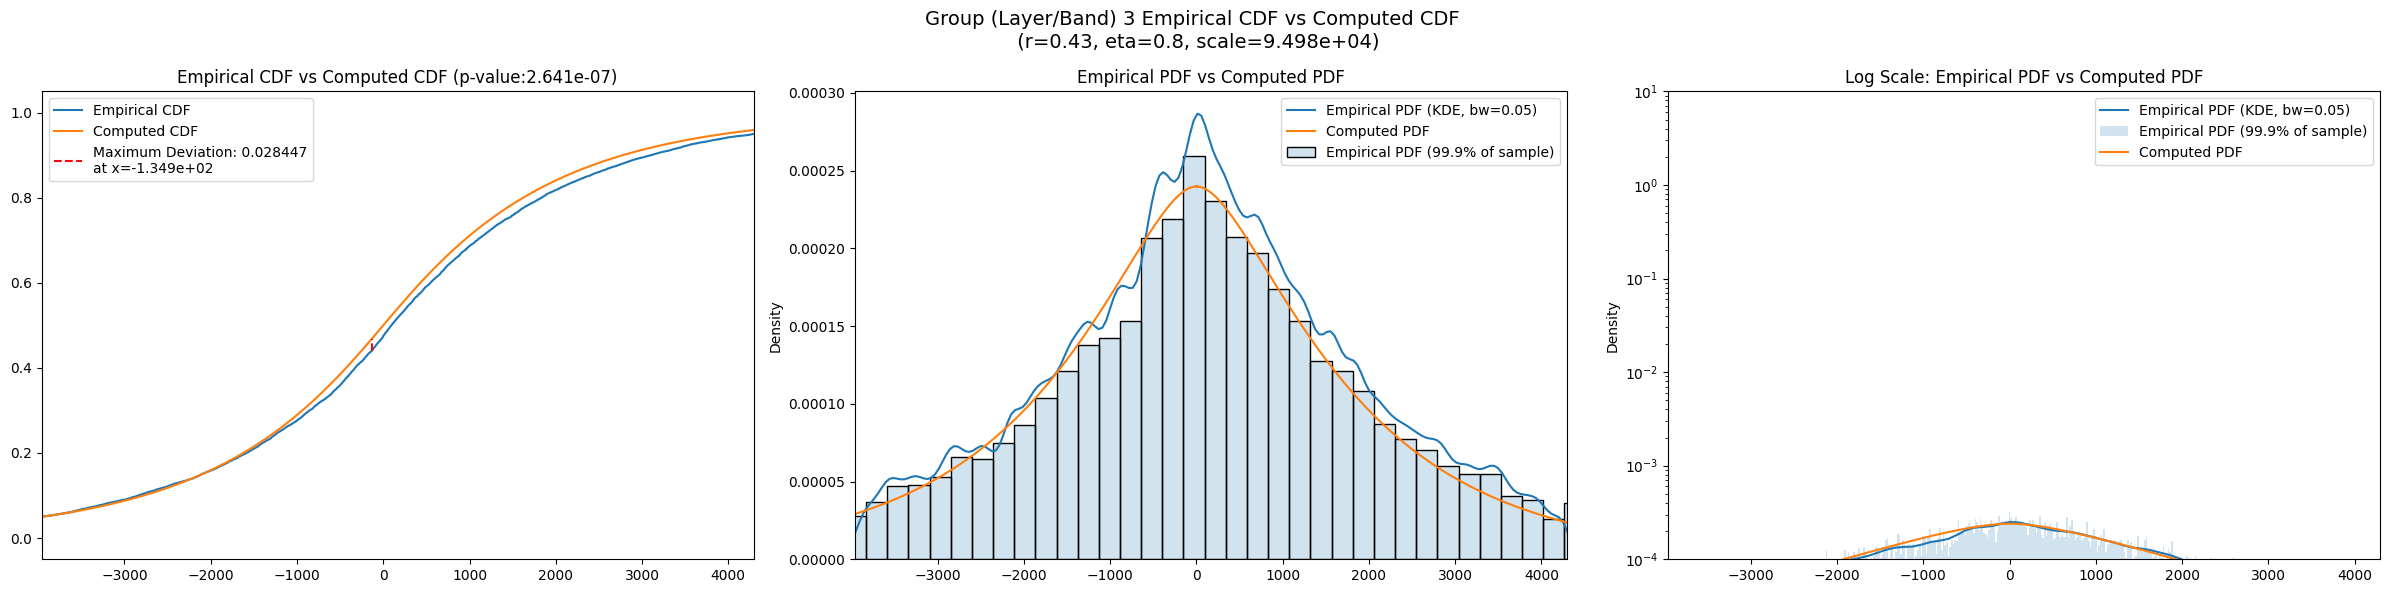

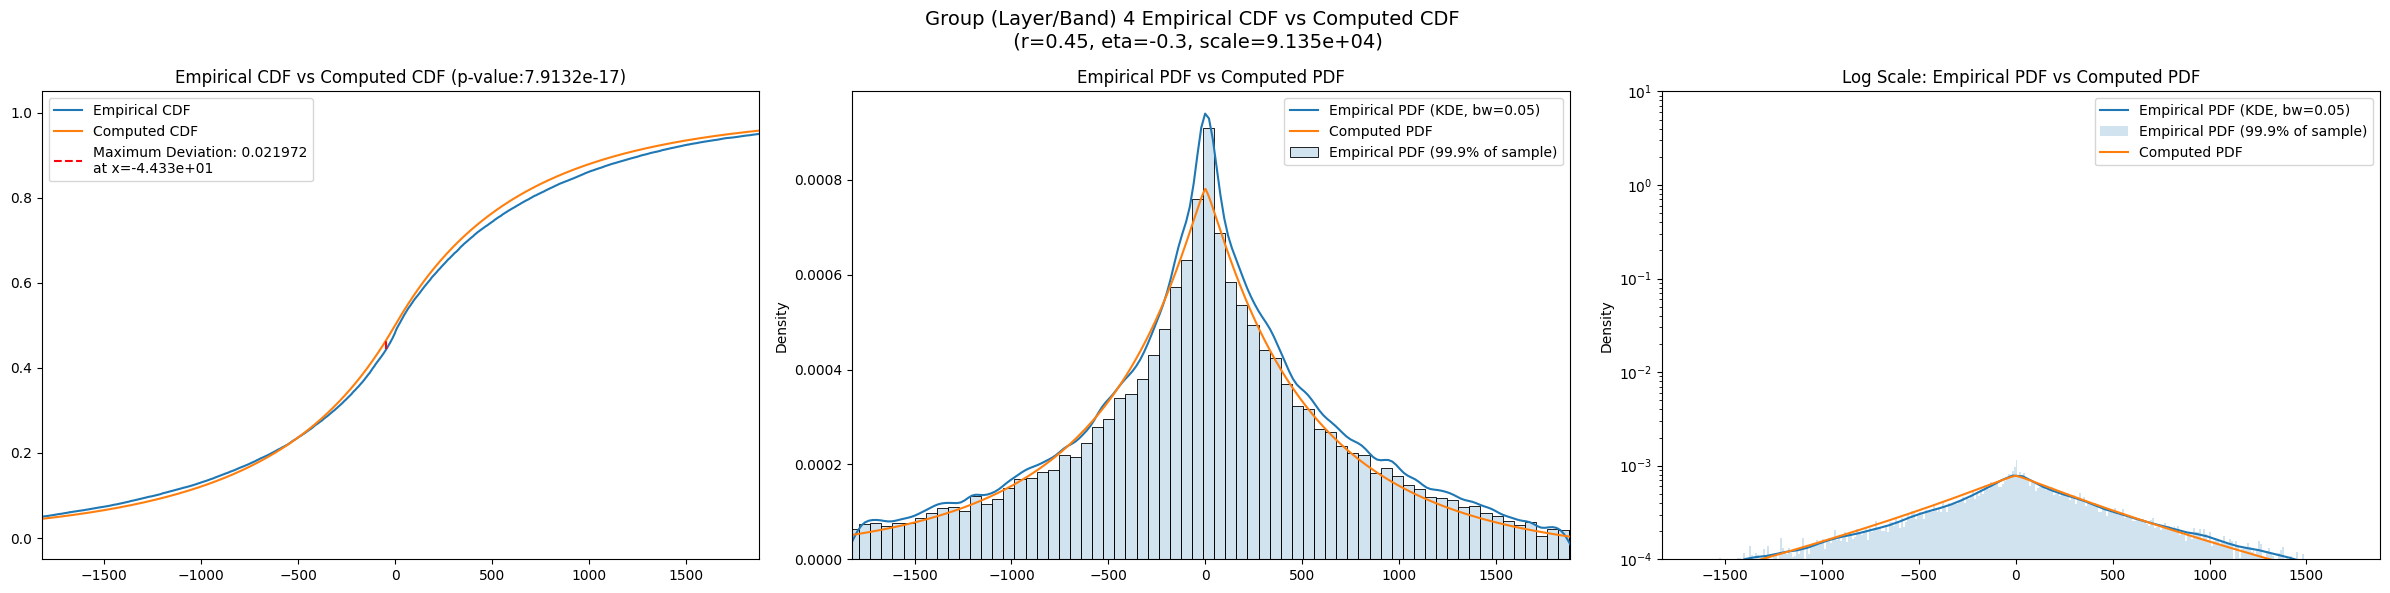

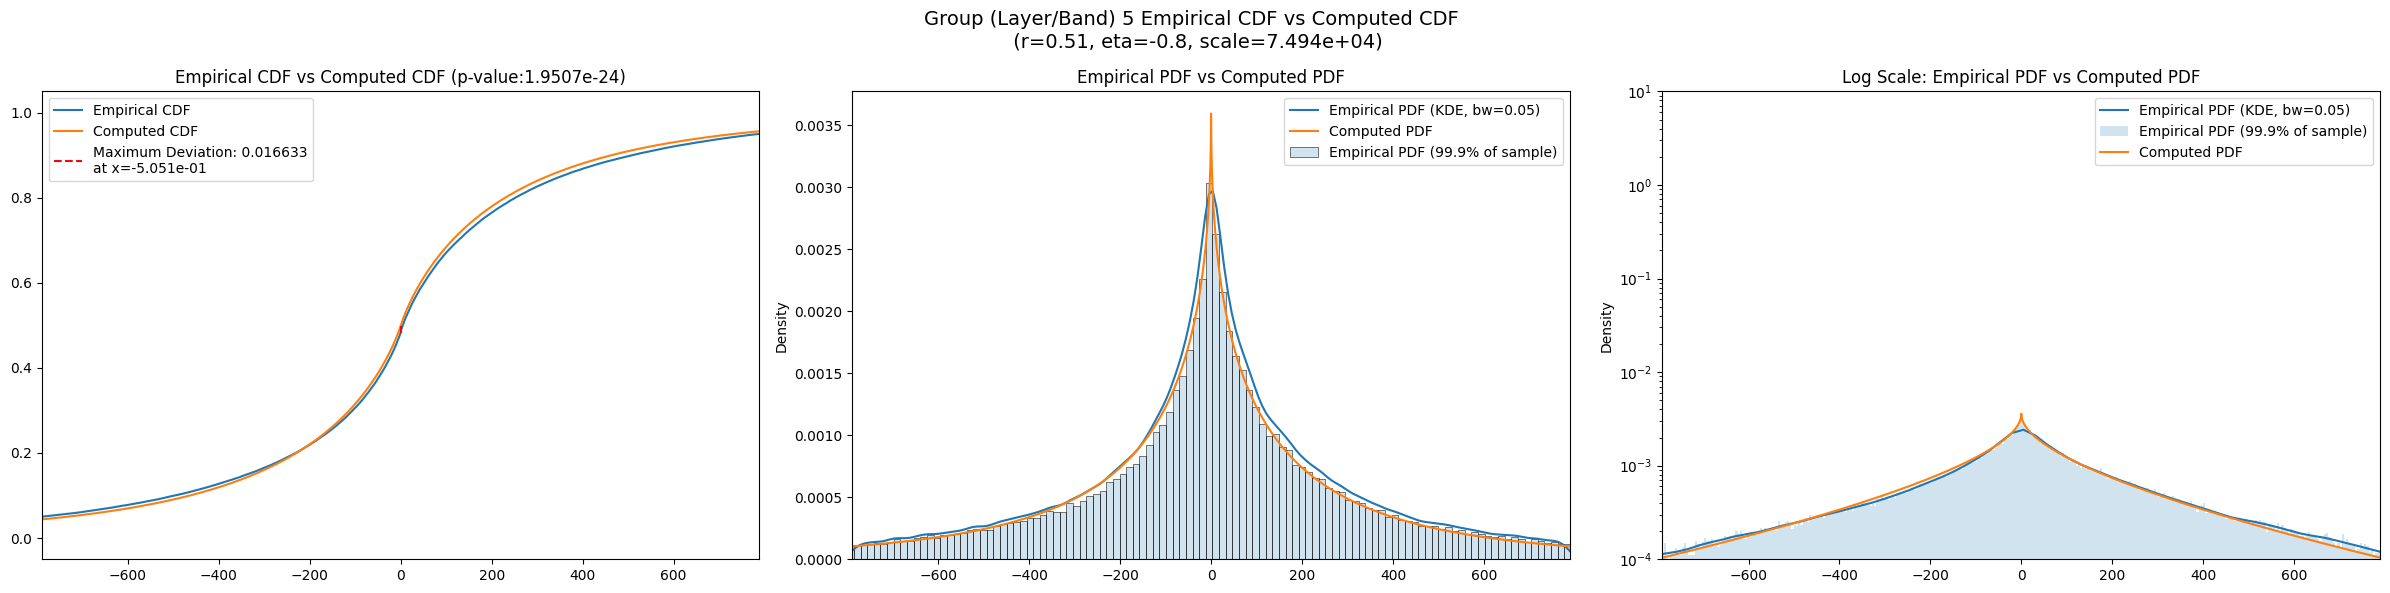

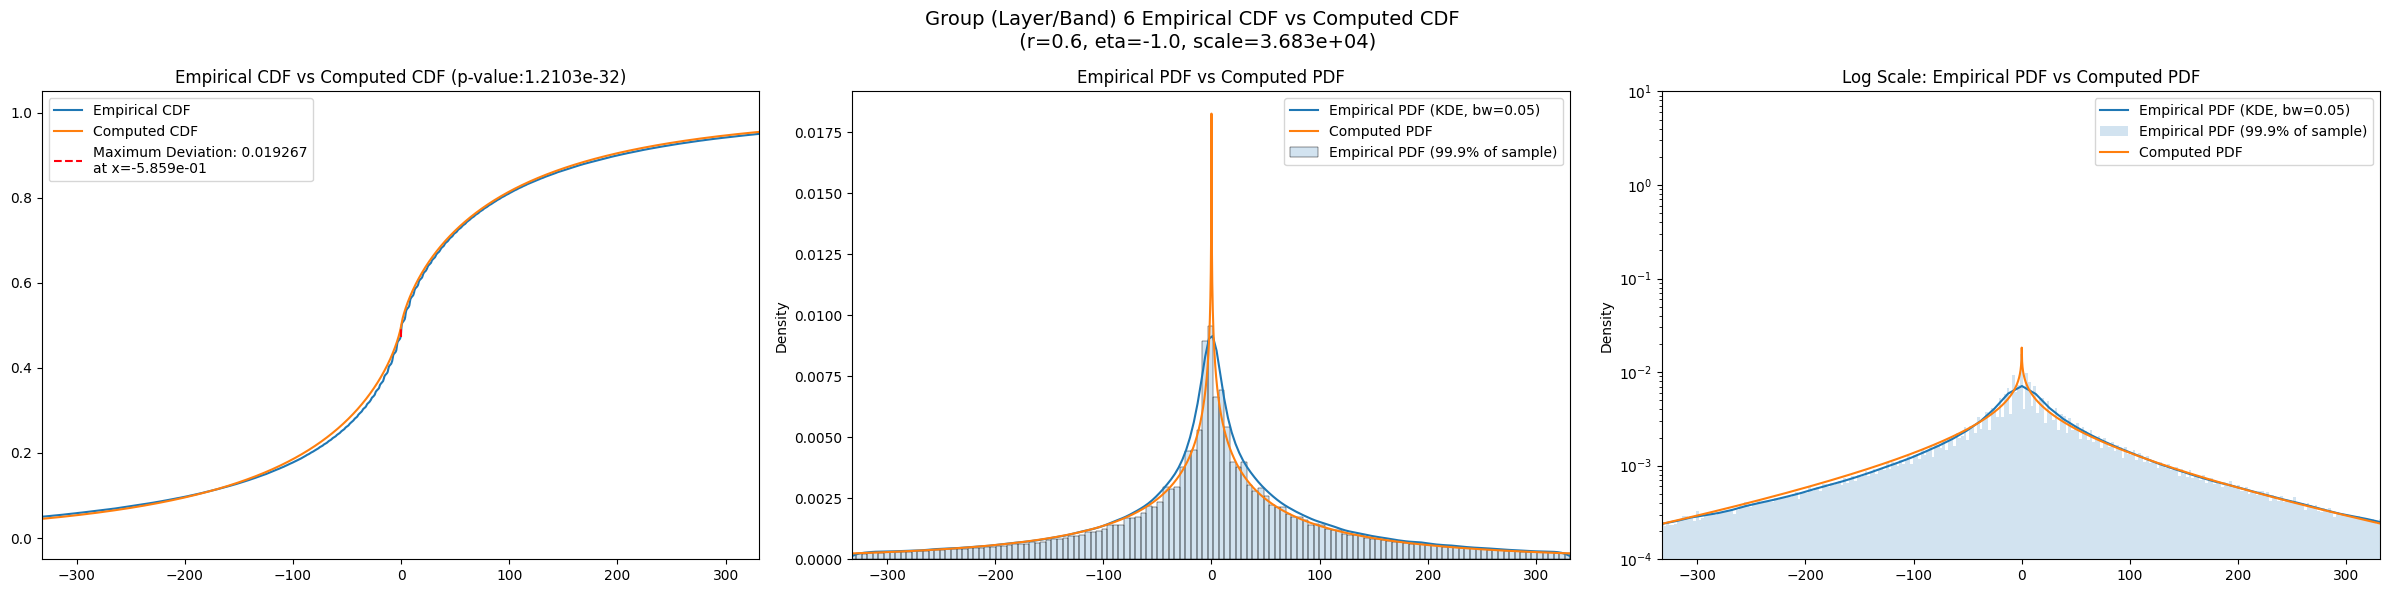

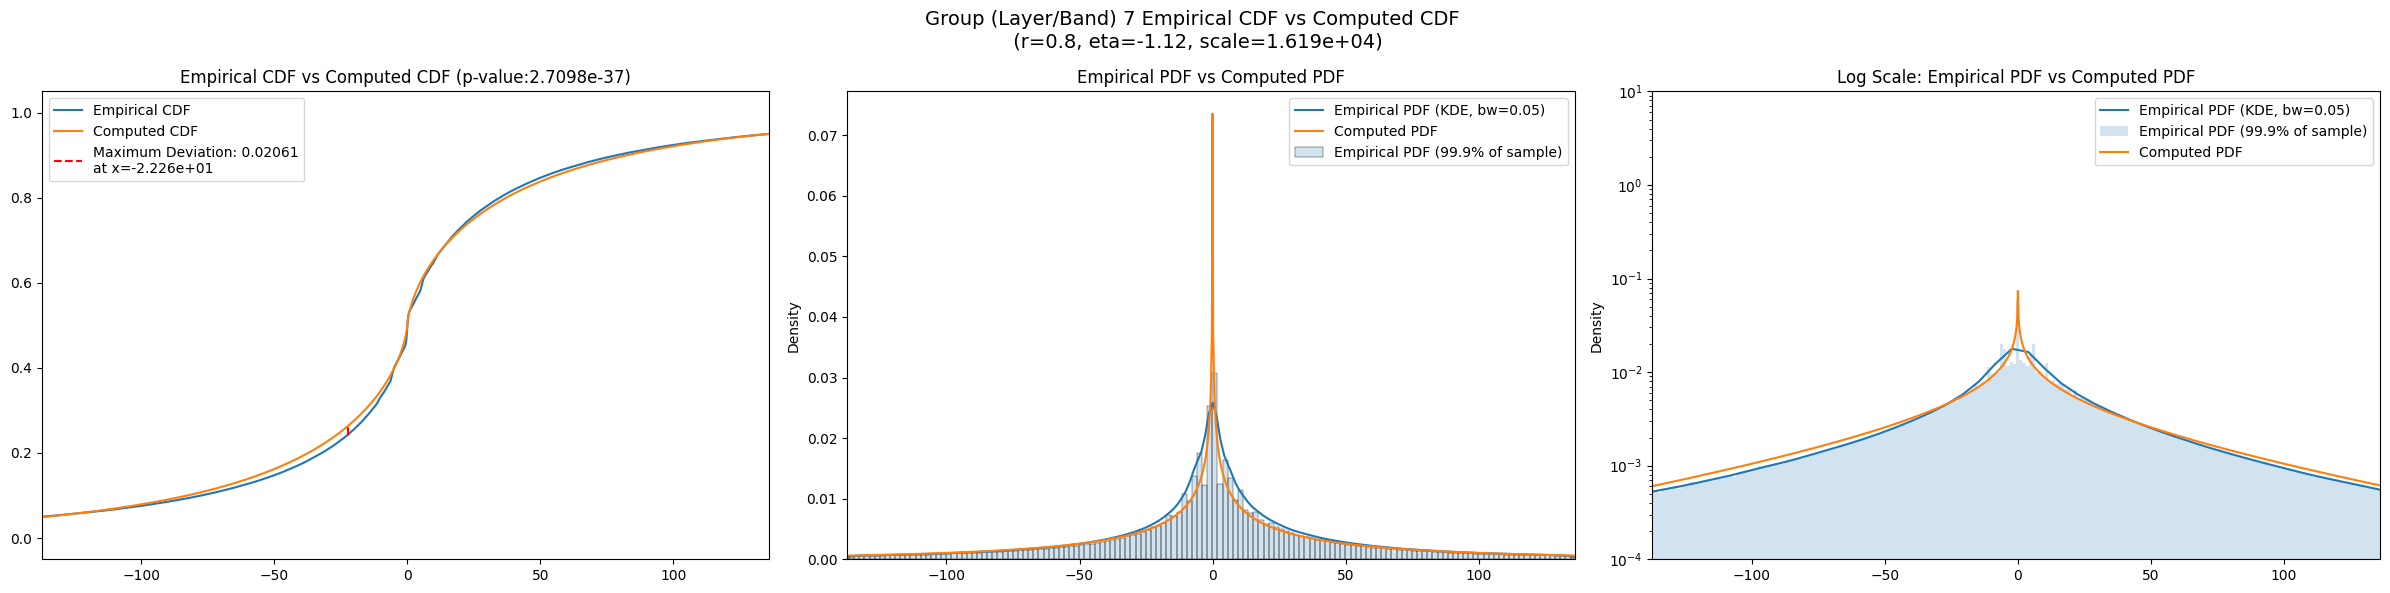

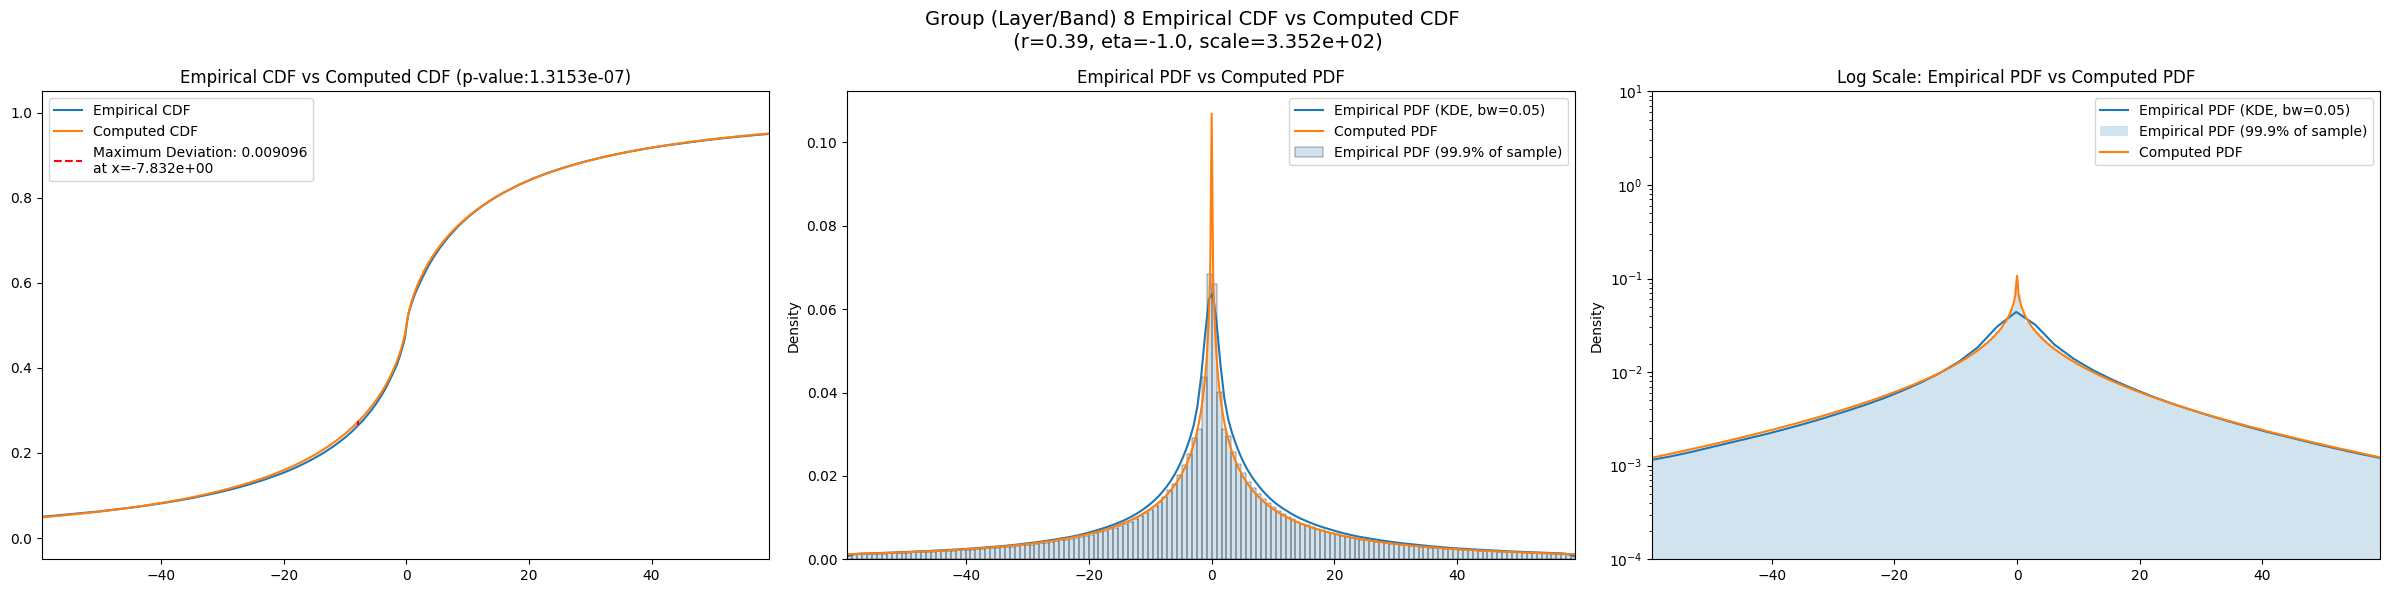

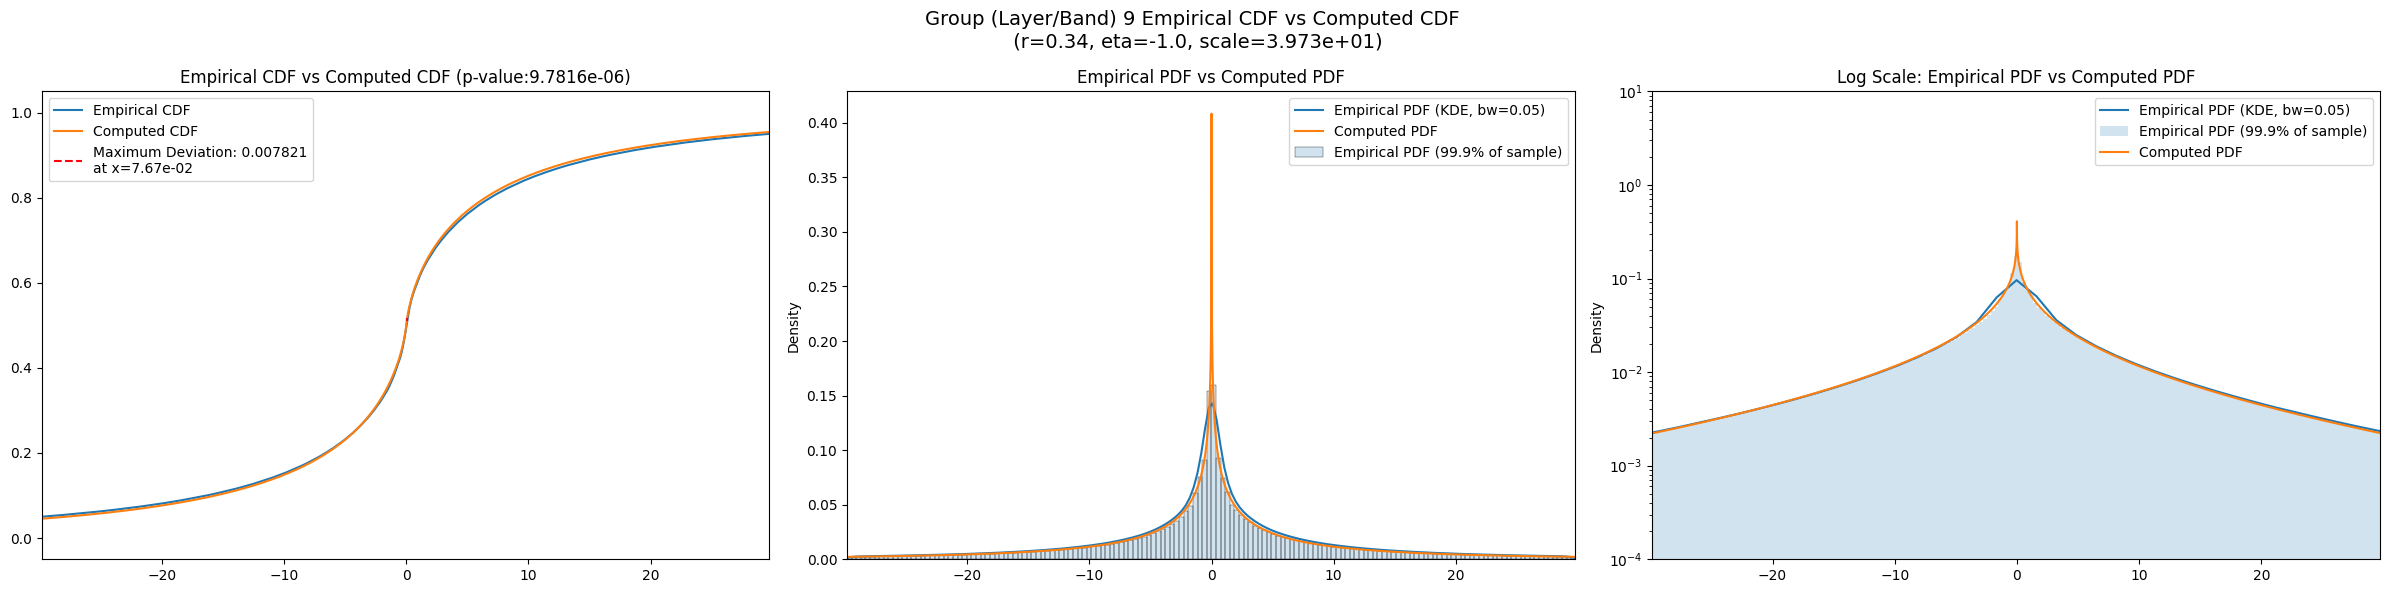

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.154161e+07  2.893149e+07  3.426387e+07   0.638397    0.345434   
3      6.082628e+06  5.795836e+06  6.381056e+06   1.415760    1.172051   
4      1.234281e+06  1.166479e+06  1.304524e+06   2.704583    2.289594   
5      2.341533e+05  2.191249e+05  2.496854e+05   4.474215    3.884163   
6      4.525257e+04  4.182397e+04  4.885501e+04   7.118702    6.031174   
7      8.730283e+03  7.959781e+03  9.548441e+03  10.400122    8.524142   
8      1.847510e+03  1.666143e+03  2.040041e+03  13.392334   10.982724   
9      4.805932e+02  4.326155e+02  5.322186e+02  14.466990   11.813130   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.948272           2446             0.036079        0.3          6.6   
3        1.673472           9784             0.028638        0.4          1.0   
4        3.160065          39136             0.023186        0.4         -0.1   
5        5.119264         156544             0.017056        0.5         -0.8   
6        8.409040         626176             0.019249        0.6         -1.0   
7       12.878841        2504704             0.021055        0.7         -1.1   
8       16.352785       10018816             0.008967        0.4         -1.0   
9       17.756971       40075264             0.010337        0.5         -1.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      5014.67000              0.040223          7.097170e-04   
3      ...      1982.20000              0.042559          7.760740e-16   
4      ...       787.56800              0.049142          1.415740e-82   
5      ...       291.57800              0.061133          0.000000e+00   
6      ...       105.84400              0.071854          0.000000e+00   
7      ...        40.76500              0.074120          0.000000e+00   
8      ...        17.50760              0.073448          0.000000e+00   
9      ...         8.24985              0.078200          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         4854.11000             0.042487         2.833960e-04  4077.99000   
3         1895.46000             0.026696         1.721340e-06  1518.43000   
4          683.95600             0.024675         3.932310e-21   568.66000   
5          250.81000             0.035021        3.003430e-167   202.41400   
6           90.37400             0.046524         0.000000e+00    72.00890   
7           34.84170             0.048957         0.000000e+00    27.42330   
8           15.10330             0.047696         0.000000e+00    11.83650   
9            7.02262             0.053753         0.000000e+00     5.48446   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.036797   2.588760e-03          3.354566e-03  
3           0.029256   1.040760e-07          2.784254e-07  
4           0.031443   4.749050e-34          9.256373e-17  
5           0.039188  2.552770e-209          5.479417e-38  
6           0.049954   0.000000e+00         5.560543e-202  
7           0.051386   0.000000e+00          0.000000e+00  
8           0.049148   0.000000e+00          0.000000e+00  
9           0.055477   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.036079                 0.027391          0.036072   
3                 0.028638                 0.013713          0.028385   
4                 0.023186                 0.006861          0.021916   
5                 0.017056                 0.003431          0.016619   
6                 0.019249                 0.001716          0.019249   
7                 0.021055                 0.000858          0.020355   
8                 0.008967                 0.000429          0.008864   
9                 0.010337                 0.000215          0.007836   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.040223             0.042487       0.036797  
3                  0.042559             0.026696       0.029256  
4                  0.049142             0.024675       0.031443  
5                  0.061133             0.035021       0.039188  
6                  0.071854             0.046524       0.049954  
7                  0.074120             0.048957       0.051386  
8                  0.073448             0.047696       0.049148  
9                  0.078200             0.053753       0.055477

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            3.154161e+07          0.036072    0.29      6.90    249.270528   
3            6.082628e+06          0.028385    0.43      0.80  94983.476467   
4            1.234281e+06          0.021916    0.45     -0.30  91347.368339   
5            2.341533e+05          0.016619    0.51     -0.80  74937.157508   
6            4.337914e+04          0.019249    0.60     -1.00  36834.667585   
7            7.932912e+03          0.020355    0.80     -1.12  16190.233085   
8            1.847510e+03          0.008864    0.39     -1.00    335.197751   
9            4.620691e+02          0.007836    0.34     -1.00     39.729830   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                     50.0  
7                    100.0  
8                      0.0  
9                     25.0

In [21]:
eng.quit()